# Breast cancer case

In [1]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from functions import crossvalidation_as_framework, random_forest_benchmark, lasso_benchmark, gradient_boosting_benchmark, elasticnet_benchmark
from seaborn import clustermap

### Load and prep data

In [60]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [61]:
# Define the target variable
target = "vital.status"

In [62]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

In [64]:
data[target].value_counts()

0    611
1     94
Name: vital.status, dtype: int64

### 2 feature models

In [5]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 50,
                                     criterion='bic',
                                     max_complexity = 3)

In [6]:
results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().roc_auc_val.std()

(0.6353392366250381, 0.07016753199242944)

In [7]:
results.groupby("fold").first().roc_auc_train.mean(), results.groupby("fold").first().roc_auc_train.std()

(0.6828421683420055, 0.043134490520034326)

In [8]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(rsCHST9*rsPCK1),647.344838,656.014947,0.665417,0.757092,0.659440,0.730496,0.346362,0.235294,"multiply(""rs_PCK1"", ""rs_CHST9"")"
1,logreg(rsAPOB*rsGPM6A),634.402481,643.072589,0.722427,0.773050,0.588870,0.737589,0.209888,0.232258,"multiply(""rs_GPM6A"", ""rs_APOB"")"
2,logreg(exp(-rsLOC283392**2 - rsOXTR**2)),635.943571,653.283788,0.665003,0.868794,0.537964,0.836879,0.226175,0.236842,"gaussian(""rs_LOC283392"", ""rs_OXTR"")"
3,logreg(exp(-rsMRAP**2 - rsOXTR**2)),660.672829,678.013046,0.629475,0.858156,0.682916,0.879433,0.437718,0.246753,"gaussian(""rs_OXTR"", ""rs_MRAP"")"
4,logreg(rsACVR1C*rsHEPACAM2),667.311813,675.981921,0.731888,0.755319,0.707506,0.758865,0.457274,0.236842,"multiply(""rs_HEPACAM2"", ""rs_ACVR1C"")"


In [9]:
for model in results.groupby("fold").first()['model_structure']:
    print(model)

logreg(rsCHST9*rsPCK1)
logreg(rsAPOB*rsGPM6A)
logreg(exp(-rsLOC283392**2 - rsOXTR**2))
logreg(exp(-rsMRAP**2 - rsOXTR**2))
logreg(rsACVR1C*rsHEPACAM2)


#### Exploration of best models

In [10]:
ql = feyn.connect_qlattice()

A new community QLattice has been allocated for you. This temporary QLattice is available for personal/non-commercial use. By using this community QLattice you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [11]:
best_models_qstrings = results.groupby("fold").first()['query_string'].values

n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        model = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)

**List of inputs**

In [12]:
inputs_list = []
for m in models_trained:
    for i in m.inputs:
        inputs_list.append(i)
        
inputs_list = list(set(inputs_list))

##### **Clustermap**

In [13]:
corr_inputs = data[inputs_list].corr()

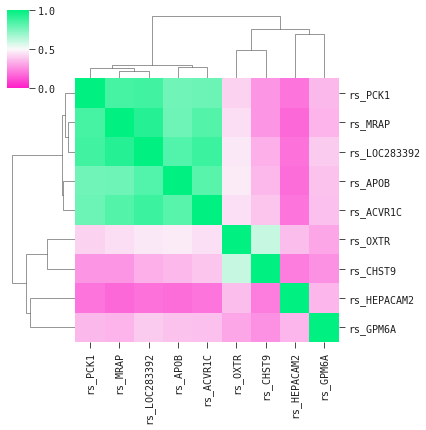

In [14]:
cluster_map_args = {'cmap': 'feyn-diverging', 'vmin': 0, 'vmax': 1}

clustermap(abs(corr_inputs), **cluster_map_args, figsize=(6, 6))
plt.savefig('../figures/bc_multi_clustermap.pdf', dpi=300, bbox_inches='tight')

In [65]:
data[inputs_list].corr()['rs_APOB'].sort_values(ascending=False)

rs_APOB         1.000000
rs_LOC283392    0.835160
rs_ACVR1C       0.822627
rs_MRAP         0.780383
rs_PCK1         0.773892
rs_OXTR         0.466882
rs_GPM6A        0.372880
rs_CHST9        0.349093
rs_HEPACAM2     0.182369
Name: rs_APOB, dtype: float64

Pairwise Pearson correlation within the main group in the heatmap above varies from ~0.77 to ~0.84

##### **Pearson correlation with output `vital.status`**

In [ ]:
scipy.stats.pearsonr(x, y)

In [66]:
pd.DataFrame(data[inputs_list].corrwith(data[target]).abs().round(3).sort_values(ascending=False), columns=['Pearson corr.'])

,Pearson corr.
rs_APOB,0.270
rs_LOC283392,0.230
rs_PCK1,0.225
rs_MRAP,0.214
rs_ACVR1C,0.206
rs_OXTR,0.194
rs_CHST9,0.139
rs_GPM6A,0.116
rs_HEPACAM2,0.051


In [68]:
print(pd.DataFrame(data[inputs_list].corrwith(data[target]).abs().round(3).sort_values(ascending=False), columns=['Pearson corr.']).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Pearson corr. \\
\midrule
rs\_APOB      &          0.270 \\
rs\_LOC283392 &          0.230 \\
rs\_PCK1      &          0.225 \\
rs\_MRAP      &          0.214 \\
rs\_ACVR1C    &          0.206 \\
rs\_OXTR      &          0.194 \\
rs\_CHST9     &          0.139 \\
rs\_GPM6A     &          0.116 \\
rs\_HEPACAM2  &          0.051 \\
\bottomrule
\end{tabular}



##### **Model response (3 examples)**

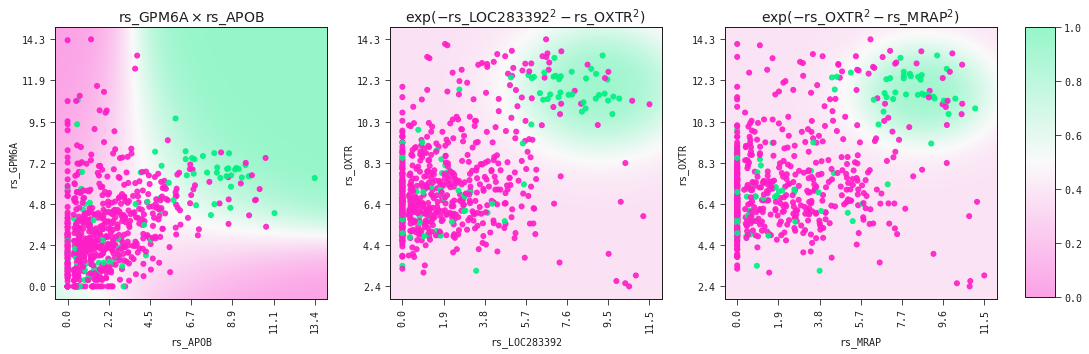

In [17]:
me0, me1, me2 = [1, 2, 3]  # 3 models chosen to be plotted

titles = [
    r'$\mathrm{rs\_GPM6A} \times \mathrm{rs\_APOB}$',
    r'$\exp(-\mathrm{rs\_LOC283392}^2 - \mathrm{rs\_OXTR}^2)$',
    r'$\exp(-\mathrm{rs\_OXTR}^2 - \mathrm{rs\_MRAP}^2)$'
]

fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i, m in enumerate([models_trained[me0], models_trained[me1], models_trained[me2]]):
    m.plot_response_2d(data, ax=axs[i])
    axs[i].set_title(titles[i])

img = axs[i].get_images()[0]
cax = fig.add_axes([0.92, 0.13, 0.025, 0.75])
fig.colorbar(img, cax=cax)
plt.savefig('../figures/bc_multi_2features_models_response2d.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Larger models

#### Default: `max_complexity = 10`

In [18]:
results10 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=10,
                                     criterion='bic')

In [19]:
results10.groupby("fold").first().roc_auc_val.mean(), results10.groupby("fold").first().roc_auc_val.std()

(0.6707620265733862, 0.04023022228709678)

In [20]:
results10.groupby("fold").first().roc_auc_train.mean(), results10.groupby("fold").first().roc_auc_train.std()

(0.7432755453894214, 0.019757174564247387)

In [21]:
results10.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(cnGBP5 + rsHS3ST4*(cnPEG3 + rsAPOB) + r...,600.705323,622.380595,0.752656,0.778369,0.674345,0.716312,0.318062,0.220690,"add(add(""cn_GBP5"", ""rs_PIK3C2G""), multiply(""rs..."
1,logreg(tanh(cnPRSS33 + rsAPOB*(cnPEG3 + rsSLC2...,578.592195,604.602520,0.711029,0.875887,0.663503,0.865248,0.267339,0.238411,"tanh(add(add(""cn_PRSS33"", ""rs_CYP4Z1""), multip..."
2,logreg(rsLGALS12*(muVPS13D + rsCLCA2 + rsSBSN ...,588.854675,610.529946,0.746748,0.820922,0.628559,0.773050,0.283315,0.238411,"multiply(""rs_LGALS12"", add(add(""mu_VPS13D"", ad..."
3,logreg(rsDPYSL5*(cnANKRD30B + cnTNFRSF11B) + t...,608.140254,634.150580,0.763776,0.780142,0.735979,0.787234,0.379609,0.250000,"add(tanh(add(""cn_BRDT"", ""rs_APOB"")), multiply(..."
4,logreg(rsFOSB*(cnACSM1*rsAPOB + ppFASN + rsTRP...,618.770019,644.780344,0.742168,0.804965,0.651424,0.780142,0.376497,0.248175,"multiply(""rs_FOSB"", add(multiply(""cn_ACSM1"", ""..."


In [22]:
for model in results10.groupby("fold").first().model_structure:
    print(model)

logreg(cnGBP5 + rsHS3ST4*(cnPEG3 + rsAPOB) + rsPIK3C2G)
logreg(tanh(cnPRSS33 + rsAPOB*(cnPEG3 + rsSLC28A3) + rsCYP4Z1))
logreg(rsLGALS12*(muVPS13D + rsCLCA2 + rsSBSN + rsSLC6A14))
logreg(rsDPYSL5*(cnANKRD30B + cnTNFRSF11B) + tanh(cnBRDT + rsAPOB))
logreg(rsFOSB*(cnACSM1*rsAPOB + ppFASN + rsTRPV6))


In [23]:
best_models_qstr_res10 = results10.groupby("fold").first()['query_string'].values

models_default = []

for i, (train, val) in enumerate(zip(train_list, val_list)):        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        models = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstr_res10[i], sample_weights=sample_weights, stypes=stypes)
        models_default.append(models[0])

## Benchmarks 

### LASSO

In [24]:
results_lasso = lasso_benchmark(data, target, num_experiments=1, n_jobs=50)

In [25]:
results_lasso

array([0.54245709, 0.5608283 , 0.62942192, 0.4866264 , 0.67083693])

In [26]:
np.mean(results_lasso)

0.5780341274796125

### Random forest

#### No feature selection

In [27]:
results_rf = random_forest_benchmark(data, target, n_jobs=50)

In [28]:
results_rf

array([0.58175248, 0.61820535, 0.65358067, 0.57808456, 0.58930112])

In [29]:
results_rf.mean()

0.6041848367865329

#### Feature selection by mutual information

In [30]:
results_rf_mi = random_forest_benchmark(data, target, feat_selection='mi', n_jobs=50)

In [31]:
results_rf_mi

array([0.62872629, 0.59188956, 0.67213115, 0.65271786, 0.61583261])

In [32]:
results_rf_mi.mean()

0.6322594938632734

#### Feature selection by f_score

In [33]:
results_rf_f = random_forest_benchmark(data, target, feat_selection='f_score', n_jobs=50)

In [34]:
results_rf_f

array([0.55826558, 0.55349439, 0.54918033, 0.49223469, 0.63589301])

In [35]:
results_rf_f.mean()

0.5578135997063163

#### Feature selection by lasso

In [36]:
results_rf_l = random_forest_benchmark(data, target, feat_selection='lasso', n_jobs=50)

In [37]:
results_rf_l

array([0.61224029, 0.6958585 , 0.70060397, 0.50905953, 0.6151855 ])

In [38]:
results_rf_l.mean()

0.6265895591081306

### Gradient Boosting

#### No feature selection

In [39]:
results_gb = gradient_boosting_benchmark(data, target)

In [40]:
results_gb

array([0.52439024, 0.69154443, 0.62467645, 0.55780846, 0.55953408])

In [41]:
results_gb.mean()

0.5915907321282013

#### Feature selection by mutual information

In [42]:
results_gb_mi = gradient_boosting_benchmark(data, target, feat_selection='mi', n_jobs=50)

In [43]:
results_gb_mi

array([0.5736224 , 0.6216566 , 0.65746333, 0.71829163, 0.47627265])

In [44]:
results_gb_mi.mean()

0.6094613226834023

#### Feature selection by f_score

In [45]:
results_gb_f = gradient_boosting_benchmark(data, target, feat_selection='f_score', n_jobs=50)

In [46]:
results_gb_f

array([0.53703704, 0.62338223, 0.56643658, 0.4799396 , 0.58024159])

In [47]:
results_gb_f.mean()

0.5574074074074075

#### Feature selection by lasso

In [48]:
results_gb_l = gradient_boosting_benchmark(data, target, feat_selection='lasso', n_jobs=50)

In [49]:
results_gb_l

array([0.66440831, 0.63136324, 0.60353753, 0.50603969, 0.59922347])

In [50]:
results_gb_l.mean()

0.6009144490352007

### Elastic net

In [51]:
results_en = elasticnet_benchmark(data, target, num_experiments=1)

/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [52]:
results_en

array([0.55555556, 0.5880069 , 0.64322692, 0.60008628, 0.66695427])

In [53]:
np.mean(results_en)

0.6107659860032595

## Summary table

In [56]:
data = [[results10.groupby("fold").first().roc_auc_val.mean(), None, None, None],
        [np.mean(results_lasso), None, None, None],
        [np.mean(results_en), None, None, None],
        [np.mean(results_rf), np.mean(results_rf_mi), np.mean(results_rf_f), np.mean(results_rf_l)],
        [np.mean(results_gb), np.mean(results_gb_mi), np.mean(results_gb_f), np.mean(results_gb_l)]
       ]
df_bench = pd.DataFrame(data=data,
             index=["QLattice", "LASSO", "Elasticnet", "Random Forest", "Gradient Boosting"],
             columns=["All features", "Feat selection MI", "Feat selection F", "Feature selection LASSO"])
df_bench.round(3)

,All features,Feat selection MI,Feat selection F,Feature selection LASSO
QLattice,0.671,NaN,NaN,NaN
LASSO,0.578,NaN,NaN,NaN
Elasticnet,0.611,NaN,NaN,NaN
Random Forest,0.604,0.632,0.558,0.627
Gradient Boosting,0.592,0.609,0.557,0.601


In [57]:
print(df_bench.round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  All features &  Feat selection MI &  Feat selection F &  Feature selection LASSO \\
\midrule
QLattice          &         0.671 &                NaN &               NaN &                      NaN \\
LASSO             &         0.578 &                NaN &               NaN &                      NaN \\
Elasticnet        &         0.611 &                NaN &               NaN &                      NaN \\
Random Forest     &         0.604 &              0.632 &             0.558 &                    0.627 \\
Gradient Boosting &         0.592 &              0.609 &             0.557 &                    0.601 \\
\bottomrule
\end{tabular}

